<a href="https://colab.research.google.com/github/FucsikovaTereza/Research_Project/blob/main/pitch_yaw_roll_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/FucsikovaTereza/Research_Project
!pip install mediapipe
%matplotlib inline
import cv2
import mediapipe as mp
import numpy as np
from PIL import Image, ImageOps
import math
from IPython.display import display
from PIL import Image as PILImage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Cloning into 'Research_Project'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 94 (delta 3), reused 3 (delta 1), pack-reused 75
Receiving objects: 100% (94/94), 242.29 MiB | 19.73 MiB/s, done.
Resolving deltas: 100% (30/30), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 10.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_

In [2]:
def get_xyz(im_path):
    # Initialize MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True, min_detection_confidence=0.5)

    # Read Image
    image = Image.open(im_path)
    gray = ImageOps.grayscale(image)

    # Convert the image to array and then to RGB
    data = np.array(gray)
    data_rgb = cv2.cvtColor(data, cv2.COLOR_GRAY2RGB)

    # Process the image with MediaPipe Face Mesh
    results = face_mesh.process(data_rgb)
    if not results.multi_face_landmarks:
        return np.nan, np.nan, np.nan  # Return NaN if no face is detected

    face_landmarks = results.multi_face_landmarks[0]
    landmark_indices = [1, 152, 33, 263, 61, 291]

    # Extract and draw the required landmarks
    for idx in landmark_indices:
        landmark = face_landmarks.landmark[idx]
        x = int(landmark.x * data_rgb.shape[1])
        y = int(landmark.y * data_rgb.shape[0])
        cv2.circle(data_rgb, (x, y), 3, (0, 255, 0), -1)

    image_points = np.array([
    (face_landmarks.landmark[idx].x * data.shape[1], face_landmarks.landmark[idx].y * data.shape[0])
    for idx in landmark_indices], dtype="double")

    # 3D model points
    model_points = np.array([
        (0.0, 0.0, 0.0),             # Nose tip
        (0.0, -330.0, -65.0),        # Chin
        (-225.0, 170.0, -135.0),     # Left eye left corner
        (225.0, 170.0, -135.0),      # Right eye right corner
        (-150.0, -150.0, -125.0),    # Left Mouth corner
        (150.0, -150.0, -125.0)      # Right mouth corner
    ])

    # Extracting X, Y, Z coordinates for plotting
    x = model_points[:, 0]
    y = model_points[:, 1]
    z = model_points[:, 2]

    # Creating a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c='red', marker='o')
    ax.plot_trisurf(x, y, z, color='lightblue', alpha=0.5)
    ax.set_title('3D Model Points Visualization')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    # Setting equal aspect ratio for all axes for better visualization
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max()+x.min()) * 0.5
    mid_y = (y.max()+y.min()) * 0.5
    mid_z = (z.max()+z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.show()

    # Camera internals
    size = data.shape
    focal_length = size[1]
    center = (size[1] / 2, size[0] / 2)
    camera_matrix = np.array(
        [[focal_length, 0, center[0]],
         [0, focal_length, center[1]],
         [0, 0, 1]], dtype="double"
    )

    # Assuming no lens distortion
    dist_coeffs = np.zeros((4, 1))

    # SolvePnP to find rotation and translation vectors
    success, rotation_vector, translation_vector = cv2.solvePnP(model_points, image_points, camera_matrix, dist_coeffs, flags=cv2.SOLVEPNP_ITERATIVE)

    # Assuming nose tip as origin for drawing axes
    nose_tip_2d = tuple(image_points[0].astype(int))

    axis = np.float32([[500,0,0], [0,500,0], [0,0,500]])
    imgpts, jac = cv2.projectPoints(axis, rotation_vector, translation_vector, camera_matrix, dist_coeffs)

    # Convert the projected points to integer before drawing
    start_point = nose_tip_2d
    end_point_x = tuple(np.int32(imgpts[0].ravel()))
    end_point_y = tuple(np.int32(imgpts[1].ravel()))
    end_point_z = tuple(np.int32(imgpts[2].ravel()))

    # Draw axes lines
    cv2.line(data_rgb, start_point, end_point_x, (255,0,0), 3)  # Blue - X axis
    cv2.line(data_rgb, start_point, end_point_y, (0,255,0), 3)  # Green - Y axis
    cv2.line(data_rgb, start_point, end_point_z, (0,0,255), 3)  # Red - Z axis

    # Calculate the Euler angles
    rvec_matrix = cv2.Rodrigues(rotation_vector)[0]
    proj_matrix = np.hstack((rvec_matrix, translation_vector))
    _, _, _, _, _, _, eulerAngles = cv2.decomposeProjectionMatrix(proj_matrix)

    # Convert radians to degrees
    pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]
    pitch = math.degrees(math.asin(math.sin(pitch)))
    roll = -math.degrees(math.asin(math.sin(roll)))
    yaw = math.degrees(math.asin(math.sin(yaw)))

    rotate_degree = (roll, pitch, yaw)
    colors = [(0, 0, 255), (255, 0, 0), (0, 255, 0)]  # Colors for each text: Blue, Green, Red
    for j, color in zip(range(len(rotate_degree)), colors):
        cv2.putText(data_rgb, ('{:05.2f}').format(float(rotate_degree[j])), (10, 30 + (50 * j)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, thickness=2, lineType=2)

    # Display the modified image
    data_rgb = cv2.cvtColor(data_rgb, cv2.COLOR_BGR2RGB)  # Convert color to RGB
    display_image = PILImage.fromarray(data_rgb)
    display(display_image)

    return pitch, roll, yaw

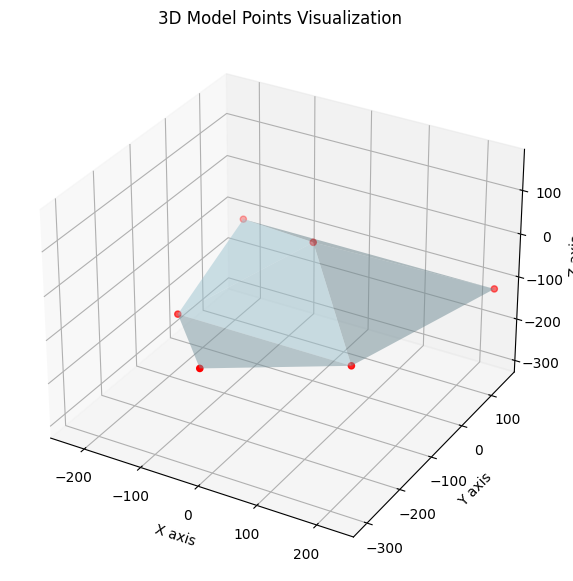

<ipython-input-2-4124eb1d110a>:110: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pitch, yaw, roll = [math.radians(_) for _ in eulerAngles]


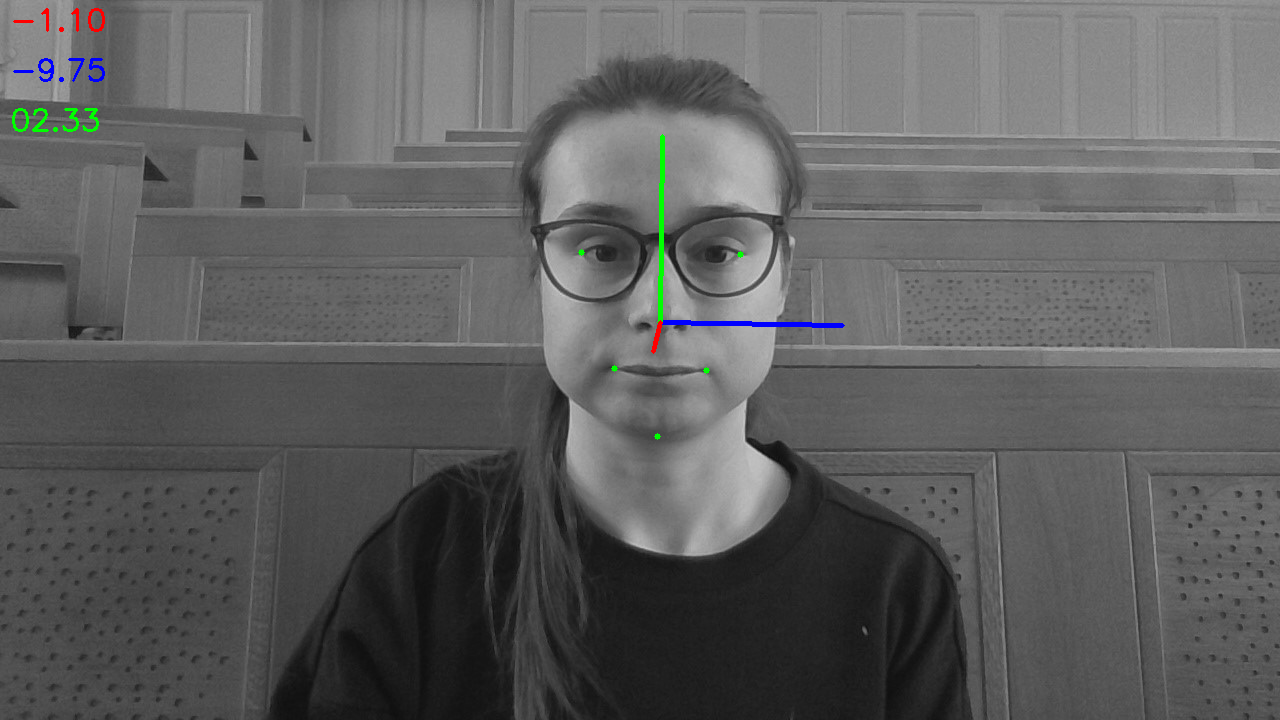

Pitch: -9.745822798869211, Yaw: 2.3285664126684282, Roll: -1.0963842428162376


In [3]:
# Calling the function
pitch, roll, yaw = get_xyz('Research_Project/pitch_yaw_roll_images/straight.jpg')
print(f"Pitch: {pitch}, Yaw: {yaw}, Roll: {roll}")